In [1]:
import torch
import torch.nn as nn
from torch import optim
from einops import rearrange

import os
import time
import glob
import datetime
from sklearn import neighbors
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix

torch.cuda.empty_cache()
torch.manual_seed(0)

In [2]:
#@title ViT Implementation 🔥
import math
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.conv =  nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool3d(kernel_size=2)
        
        
    def forward(self, x):
        return self.maxpool(self.act((self.bn(self.conv(x)))))

class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        # self.num_patches = (self.image_size // self.patch_size) ** 3
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.conv_1 = ConvBlock(self.num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = ConvBlock(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv_4 = ConvBlock(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv_5 = ConvBlock(256, 512, kernel_size=3, stride=1, padding=1)
        self.num_patches = 512
        #self.projection = nn.Conv3d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_depth, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        #x = self.projection(x)
        x = rearrange(x, 'b c d w h -> b c (d w h)')
        
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.attention_pool = nn.Linear(self.hidden_size, 1)
        self.classifier = nn.Linear(2*self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        cls_logits, activation_logits = encoder_output[:, 0, :], encoder_output[:, 1:, :]
        activation_logits = torch.matmul(nn.functional.softmax(self.attention_pool(activation_logits), dim=1).transpose(-1, -2), activation_logits).squeeze(-2)
        logits = torch.cat((cls_logits, activation_logits), dim=1)
        logits = self.classifier(logits)
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

In [3]:
config = {
    'batch_size' : 3,
    'image_size' : 192,
    'patch_size' : 6,
    "hidden_size": 216,
    "num_hidden_layers": 3,
    "num_attention_heads": 8,
    "intermediate_size": 3 * 216, # 3 * hidden_size
    "hidden_dropout_prob": 0.25,
    "attention_probs_dropout_prob": 0.25,
    "initializer_range": 0.02,
    "num_classes": 3, # num_classes
    "num_channels": 1,
    "qkv_bias": True,
    "use_faster_attention": True,
    'lr' : 1e-5,
    'save_model_every' : 0,
    'exp_name' : 'Visualization',
    'epochs' : 50,
    'model_name': 'Hybrid-Finetune',
    'chkp-file': "/home/admin1/Arindam/Alzheimer/ViT/experiments/Hybrid-Finetune/model_best_finetuned.pt"
}

In [4]:
#@title Prepare Data 📊
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

class FolderDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.image_paths = glob.glob(f'{self.folder}/*/*.pt')
        self.labels = {
            'CN' : 0,
            'MCI' : 1,
            'AD' : 2
        }
        self.transform = False #tio.transforms.Compose(
            #[tio.transforms.RandomAffine(degrees=5)
            #tio.transforms.RandomBiasField()])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __label_dist__(self):
        cn,mci, ad = 0, 0, 0
        for path in self.image_paths:
            if self.__label_extract__(path) == 0:
                cn += 1
            elif self.__label_extract__(path) == 1:
                mci += 1
            elif self.__label_extract__(path) == 2:
                ad += 1
        
        return {'CN': cn, 'MCI': mci, 'AD': ad}
    
    def __label_extract__(self, path):
        if 'CN' in path:
            return 0
        elif 'MCI' in path:
            return 1
        elif 'AD' in path:
            return 2
        
    def __getitem__(self, idx):
        tensor, label = torch.load(self.image_paths[idx]), self.__label_extract__(self.image_paths[idx])
        if self.transform:
            tensor = self.transform(tensor)
        
        return tensor, label
    
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    train_dataset = FolderDataset(folder='/home/arindam/Alzheimer/ViT/data/3D (part II)/Train')
    val_dataset = FolderDataset(folder='/home/arindam/Alzheimer/ViT/data/3D (part II)/Val')
    test_dataset = FolderDataset(folder='/home/arindam/Alzheimer/ViT/data/3D (part II)/Test')

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    classes = ('CN', 'MCI', 'AD')
    class_dist = {
        'Train': train_dataset.__label_dist__(),
        'Val': val_dataset.__label_dist__(),
        'Test': test_dataset.__label_dist__()
    }
    
    return train_loader, valid_loader, test_loader, class_dist


def visualize_images(dataset, cmap='gray'):
    outdir = os.path.join("experiments", config['exp_name'])
    os.makedirs(outdir, exist_ok=True)
    classes = ('CN', 'MCI', 'AD')

    # Pick 3 samples randomly
    indices = torch.randperm(len(dataset))
    idx = []
    for i in indices:
        if dataset[i][1]==0:
            idx.append(i)
            break
    for i in indices:
        if dataset[i][1]==1:
            idx.append(i)
            break
    for i in indices:
        if dataset[i][1]==2:
            idx.append(i)
            break
            
    indices = idx
    images = [np.asarray(dataset[i][0]) for i in indices]
    labels = [dataset[i][1] for i in indices]
    # Visualize the images using matplotlib
    fig = plt.figure(figsize=(10, 10))
    for i in range(3):
        img = np.squeeze(images[i])
        img_1 = img[img.shape[0]//2, :, :]
        ax = fig.add_subplot(3, 3, 3*i+1, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_1), cmap=cmap)
        ax.set_title(f"{classes[labels[i]]} (sagital)")
        
        img_2 = img[:, img.shape[1]//2, :]
        ax = fig.add_subplot(3, 3, 3*i+2, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_2), cmap=cmap)
        ax.set_title(f"{classes[labels[i]]} (coronal)")
        
        img_3 = img[:, :, img.shape[2]//2]
        ax = fig.add_subplot(3, 3, 3*i+3, xticks=[], yticks=[])
        ax.imshow(np.rot90(img_3), cmap=cmap)
        ax.set_title(f"{classes[labels[i]]} (axial)")
    
    plt.savefig(f"experiments/{config['exp_name']}/samples_hot.png", dpi=600, bbox_inches='tight')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


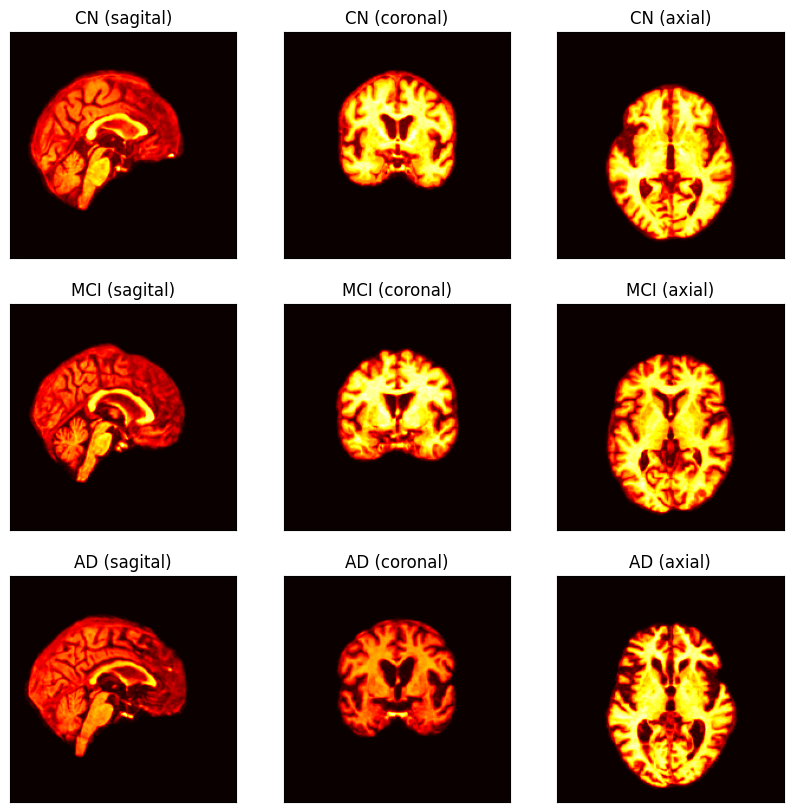

In [5]:
test_dataset = FolderDataset(folder='/home/admin1/Arindam/Alzheimer/ViT/data/3D (part II)/Test')
visualize_images(test_dataset, cmap='hot')

In [6]:
from scipy.ndimage import zoom

In [7]:
model_cpfile = config['chkp-file']
save_dir = os.path.join("experiments", config['exp_name'])
os.makedirs(save_dir, exist_ok=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


def load_model(model_cp_path, model_config):
    model = ViTForClassfication(model_config).to(device)
    model.load_state_dict(torch.load(model_cp_path))
    return model


def get_last_layer_activations_grds(model, x):
    x = torch.from_numpy(x)
    if x.dim()==4:
        x = torch.unsqueeze(x, dim=0)
    x = x.to(device)
    h = model.embedding.patch_embeddings.conv_5.maxpool.register_forward_hook(get_activation('last_layer'))
    output, attention_maps = model(x, output_attentions=True)
    h.remove()
    forward_features = activation['last_layer']
    #forward_features[forward_features < 0] = 0
    
    """
    loss = loss_fn(model(x)[0], y)
    loss.backward()
    gradients = model.embedding.patch_embeddings.conv_5.conv.weight.grad
    pooled_gradients = torch.mean(gradients, dim=[1, 2, 3, 4])
    pooled_gradients = pooled_gradients/torch.max(pooled_gradients)
    pooled_gradients[pooled_gradients < 0] = 0
    """
    return output, forward_features, attention_maps


def get_class_attention_coefficients(attention_maps: list):
    attention_maps = torch.cat(attention_maps, dim=1)
    # select only the attention maps of the CLS token
    attention_coeff = attention_maps[:, :, 0, 1:] 
    attention_coeff = torch.sum(attention_coeff, dim=1)
    attention_coeff = torch.squeeze(attention_coeff)
    attention_coeff = attention_coeff/torch.max(attention_coeff)
    return attention_coeff


def get_heatmap(model, forward_attentions, attention_coeff, return_map=True):
    forward_attentions = torch.squeeze(forward_attentions)
    for i in range(512):
        #forward_attentions[i, :, :, :] *= pooled_gradients[i]
        forward_attentions[i, :, :, :] *= attention_coeff[i]
    heatmap = torch.mean(forward_attentions, dim=0)
    heatmap = heatmap.detach().cpu().numpy()
    heatmap = np.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    upscaled_heatmap = zoom(heatmap, (32, 32, 32), mode='nearest')

    upscaled_heatmap = np.uint8(upscaled_heatmap*255)

    if return_map:
        return heatmap, upscaled_heatmap
    else:
        return upscaled_heatmap

def plot_class_attention_map(attention_coeff, tag='label', cmap='hot'):
    h, w = 32, 16
    assert attention_coeff.size(dim=0) == h*w

    class_attention_map = attention_coeff.view(h, w)
    class_attention_map = class_attention_map/torch.max(class_attention_map)
    class_attention_map = class_attention_map.detach().cpu().numpy()
    class_attention_map = np.uint8(class_attention_map*255)
    
    return class_attention_map

In [8]:
model = load_model(model_cpfile, config)
loss_fn = nn.CrossEntropyLoss()

In [9]:
indices = torch.randperm(len(test_dataset))
idx = []
for i in indices:
    if test_dataset[i][1]==0:
        idx.append(i)
        break
for i in indices:
    if test_dataset[i][1]==1:
        idx.append(i)
        break
for i in indices:
    if test_dataset[i][1]==2:
        idx.append(i)
        break

indices = idx #[50, 217, 265]
images = [np.asarray(test_dataset[i][0]) for i in indices]
labels = [test_dataset[i][1] for i in indices]
print(indices, labels)

[tensor(248), tensor(195), tensor(65)] [0, 1, 2]


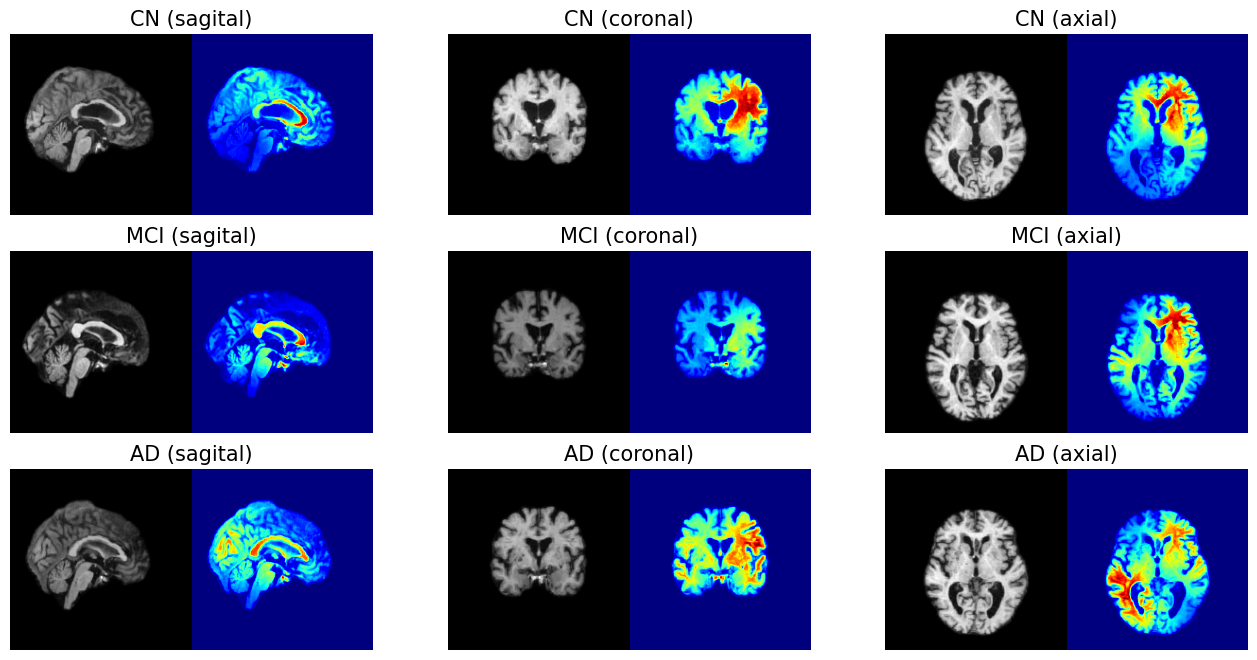

In [17]:
labels_dict = {
    0: 'CN',
    1: 'MCI',
    2: 'AD'
}

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
heats = []
for i in range(len(indices)):
    x, y = images[i], labels[i]
    model.eval()
    yhat, forward_features, attention_maps = get_last_layer_activations_grds(model, x)
    attention_coeff = get_class_attention_coefficients(attention_maps)
    heatmap, upscaled_heatmap = get_heatmap(model, forward_features, attention_coeff)
    upscaled_heatmap = upscaled_heatmap * x[0]
    upscaled_heatmap = upscaled_heatmap/np.max(upscaled_heatmap)
    heats.append(heatmap)
    
    x = np.squeeze(x)
    slice_idx = x.shape[0]//2
    sagital = np.rot90(x[slice_idx, :, :])
    sagital_heatmap = np.rot90(upscaled_heatmap[slice_idx, :, :])
    coronal = np.rot90(x[:, slice_idx, :])
    coronal_heatmap = np.rot90(upscaled_heatmap[:, slice_idx, :])
    axial = np.rot90(x[:, :, slice_idx])
    axial_heatmap = np.rot90(upscaled_heatmap[:, :, slice_idx])
    
    mask = np.concatenate((np.ones((192, 192)), np.zeros((192, 192))), axis=1)
    sagital = np.concatenate((sagital, sagital), axis=1)
    sagital_heatmap = np.concatenate((sagital_heatmap, sagital_heatmap), axis=1)
    sagital_heatmap = np.ma.masked_where(mask==1, sagital_heatmap)
    coronal = np.concatenate((coronal, coronal), axis=1)
    coronal_heatmap = np.concatenate((coronal_heatmap, coronal_heatmap), axis=1)
    coronal_heatmap = np.ma.masked_where(mask==1, coronal_heatmap)
    axial = np.concatenate((axial, axial), axis=1)
    axial_heatmap = np.concatenate((axial_heatmap, axial_heatmap), axis=1)
    axial_heatmap = np.ma.masked_where(mask==1, axial_heatmap)
    
    
    axes[i][0].imshow(sagital, cmap='gray')
    axes[i][0].imshow(sagital_heatmap, alpha=1, cmap='jet')
    axes[i][1].imshow(coronal, cmap='gray')
    axes[i][1].imshow(coronal_heatmap, alpha=1, cmap='jet')
    axes[i][2].imshow(axial, cmap='gray')
    axes[i][2].imshow(axial_heatmap, alpha=1, cmap='jet')
    
    axes[i][0].axis(False)
    axes[i][1].axis(False)
    axes[i][2].axis(False)

for i in range(len(indices)):
    for j in range(3):
        axes[i][0].set_title(f"{labels_dict[labels[i]]} (sagital)", fontsize=15)
        axes[i][1].set_title(f"{labels_dict[labels[i]]} (coronal)", fontsize=15)
        axes[i][2].set_title(f"{labels_dict[labels[i]]} (axial)", fontsize=15)

plt.savefig(os.path.join(save_dir, 'heatmap_vis.png'), dpi=900, bbox_inches='tight')

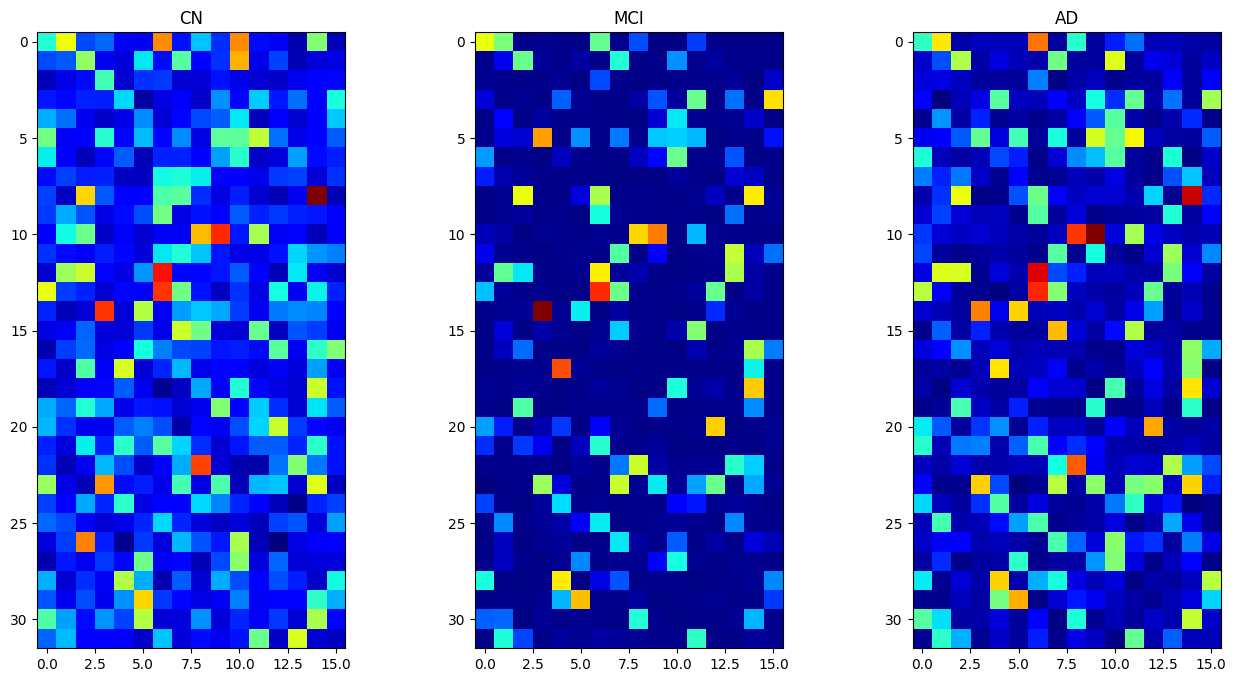

In [12]:
labels_dict = {
    0: 'CN',
    1: 'MCI',
    2: 'AD'
}

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for i in range(len(indices)):
    x, y = images[i], labels[i]
    model.eval()
    yhat, forward_features, attention_maps = get_last_layer_activations_grds(model, x)
    attention_coeff = get_class_attention_coefficients(attention_maps)
    class_attention_map = plot_class_attention_map(attention_coeff, tag=labels_dict[y])
    axes[i].imshow(class_attention_map, cmap='jet')
    axes[i].set_title(labels_dict[y]) 

plt.savefig(os.path.join(save_dir, 'class_activation_map.png'), dpi=600, bbox_inches='tight')